<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/sythetic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.experimental import stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

In [2]:
# Skips any tests and just runs function definitions
run_tests = True

# Synthetic Data

#### Function Defs

In [184]:
def generateWordBank(toy_params):
  """
  Creates the word bank based on various inputs
  """

  context_words = toy_params['context_words']
  variable_length = toy_params['variable_length']
  unordered = toy_params['unordered_class']
  if unordered:
    words = []
    n_unordered = toy_params['n_unordered']
    for i in range(n_unordered):
      words.extend(['kinda'+str(i), 'very'+str(i)])
  else:
    words = ['awful', 'bad', 'good', 'awesome']
  
  # words.extend(['the', 'the2', 'the3', 'the4', 'the5'])
  words.extend(['the'])

  if context_words:
    words.extend(['not', 'extremely'])
  if variable_length:
    words.append('<EoS>')

  return words

def make_toy_phrase(toy_params):
  """
  Creates a single toy phrase
  """
  
  phrase_length = toy_params['phrase_length']
  words = toy_params['words']
  variable_length = toy_params['variable_length']
  min_phrase_len = toy_params['min_phrase_len']

  phrase = []
  n_words = len(words)
  # Sets phrase length, allowing for variable length
  if variable_length:
    length = min_phrase_len + np.random.randint(phrase_length - min_phrase_len)
  else:
    length = phrase_length
  
  for idx in range(length):
    next_word = False
    while not next_word:
      next_word = False
      # Create the white noise input.
      word_idx = np.random.randint(n_words)
      if words[word_idx] == 'extremely' and idx > 0: # No repeat 'extremely'
        if phrase[idx-1] != 'extremely':
          next_word = True
      elif words[word_idx] == 'not' and idx > 0: # No repeat 'not'
        found_not = False
        for idx2 in range(1, min(4, idx+1)): # up to 4 words back
          if phrase[idx-idx2]== 'not':
            found_not = True
        if not found_not:
          next_word = True
      elif words[word_idx] != '<EoS>':
        next_word = True
    phrase.append(words[word_idx])

  # Adds EoS at end for variable length phrases
  if variable_length:
    phrase.append('<EoS>')
  
  return phrase

def eval_toy_phrase(toy_phrase, toy_params):
  """
  Evaluates a single toy phrase and returns a score
  """
  max_phrase_length = toy_params['phrase_length']
  unordered = toy_params['unordered_class']

  if unordered:
    n_unordered = toy_params['n_unordered']
    score = np.zeros((n_unordered,))
    base_word_vals = {}
    # for i in range(n_unordered):
    #   base_word_vals['kinda'+str(i)] = np.zeros((n_unordered,))
    #   base_word_vals['kinda'+str(i)][i] = 1
    #   base_word_vals['very'+str(i)] = np.zeros((n_unordered,))
    #   base_word_vals['very'+str(i)][i] = 2
    # base_word_vals['kinda01'] = np.zeros((n_unordered,))
    # base_word_vals['kinda01'][0] = 1/2
    # base_word_vals['kinda01'][1] = 1/2
    base_word_vals['kinda0'] = np.asarray([1, 1/3])
    base_word_vals['kinda1'] = np.asarray([0, 2/3])
  else:
    score = 0
    base_word_vals = {'awful': -2, 'bad': -1, 'the': 0, 'good': 1, 'awesome': 2}
  phrase_length = len(toy_phrase)
  extreme_length = 0 # range of influence of extreme
  not_length = 0 # range of influence of not

  for idx in range(phrase_length):
    if toy_phrase[idx] in list(base_word_vals.keys()):
      base_score = base_word_vals[toy_phrase[idx]]
      if not_length > 0: 
        base_score = -1 * base_score
      if extreme_length > 0: 
        base_score = 2 * base_score
      score += base_score
    elif toy_phrase[idx] == 'not':
      not_length = 4
    elif toy_phrase[idx] == 'extremely':
      extreme_length = 2
    elif toy_phrase[idx] == '<EoS>': break
    
    if not_length > 0: not_length -= 1 # decays not
    if extreme_length > 0: extreme_length -= 1 # decays extremely
  
  # Normalizes by approximate variance
  score /= np.sqrt(2 * max_phrase_length)

  return score

def wordToIndex(word, word_bank):
  """
  Converts a word into corresponding index in words
  """
  return word_bank.index(word)

def wordToTensor(word, word_bank):
  """ Turn a letter into a <1 x n_words> Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  tensor[0][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def phraseToTensor(phrase, word_bank):
  """
  Turn a phrase into a <phrase_length x n_words> (an array of one-hot letter vectors)
  """
  n_words = len(word_bank)
  tensor = np.zeros((len(phrase), n_words))
  for wi, word in enumerate(phrase):
      tensor[wi][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def classifySentiment(score, toy_params):
  """
  Turns a score of a toy phrase into a sentiment and corresponding tensor
  Contains definitions of thresholds for dividing into multiple classes
  """
  sentiments = toy_params['sentiments']
  unordered = toy_params['unordered_class']
  loss_type = toy_params['loss_type']
  phrase_length = toy_params['phrase_length']

  n_sentiments = len(sentiments)

  if unordered:
    sentiment = 'sent'+str(np.argmax(score))
    sentiment_tensor_final = np.zeros((n_sentiments,))
    sentiment_tensor_final[np.argmax(score)] = 1.0
    sentiment_tensor = np.array([np.zeros((n_sentiments,)) if idx != phrase_length-1 else sentiment_tensor_final for idx in range(phrase_length)])
  else:
    # Used for 3-class sentiment analysis, about 1/3 will be neutral
    neutral_thresh = 0.43

    # 5-class sentiment analysis, about 1/5 will be of each class
    three_star_thresh = 0.253
    four_star_thresh = 0.843

    if loss_type == 'XE':
      if n_sentiments == 2:
        if score >= 0:
          sentiment = 'Good'
        else:
          sentiment = 'Bad'
      elif n_sentiments == 3:
        if score >= neutral_thresh:
          sentiment = 'Good'
        elif score <= -1 * neutral_thresh:
          sentiment = 'Bad'
        else:
          sentiment = 'Neutral'
      elif n_sentiments == 5:
        if score > four_star_thresh:
          sentiment = 'Five'
        elif score > three_star_thresh:
          sentiment = 'Four'
        elif score > -1 * three_star_thresh:
          sentiment = 'Three'
        elif score > -1 * four_star_thresh:
          sentiment = 'Two'
        else:
          sentiment = 'One'
      sentiment_tensor_final = np.zeros((n_sentiments,))
      sentiment_tensor_final[sentiments.index(sentiment)] = 1.0
      sentiment_tensor = np.array([np.zeros((n_sentiments,)) if idx != phrase_length-1 else sentiment_tensor_final for idx in range(phrase_length)])
    elif loss_type == 'MSE':
        sentiment = score
        sentiment_tensor = np.array([[0.0] if idx != phrase_length-1 else [score] for idx in range(phrase_length)])
  
  return sentiment, sentiment_tensor

def randomTrainingExample(toy_params):
  """
  Generates a random training example consisting of phrase and sentiment and corresponding tensors

  Returns:
  sentiment_tensor: time x input dim (word bank size)
  sentiment_tensor: 1 x output dim (sentiment bank size)

  """
  # Unpacks toy_params (with defaults)
  phrase_length = toy_params['phrase_length']
  words = toy_params['words']
  sentiments = toy_params['sentiments']
  loss_type = toy_params['loss_type'] if 'loss_type' in toy_params else 'XE'
  variable_length = toy_params['variable_length'] if 'variable_length' in toy_params else 'False'
  min_phrase_len = toy_params['min_phrase_len'] if 'min_phrase_len' in toy_params else 10
  unordered_class = toy_params['unordered_class'] if 'unordered_class' in toy_params else 'False'

  phrase = make_toy_phrase(toy_params)
  score = eval_toy_phrase(phrase, toy_params)
  
  sentiment, sentiment_tensor = classifySentiment(score, toy_params)
  targets_t = np.zeros(phrase_length-1)

  phrase_tensor = phraseToTensor(phrase, words)
  target_mask = np.array([len(phrase)-1], dtype=int) # When target is defined.
  
  return sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask

def default_params(toy_params):
  """ Sets the defaults of many parameters if not specified"""
  if 'variable_length' not in toy_params: toy_params['variable_length'] = False
  if 'unordered_class' not in toy_params: toy_params['unordered_class'] = False
  if 'min_phrase_len' not in toy_params: toy_params['min_phrase_len'] = 10

  return toy_params

#### Toy Data Tests

In [4]:
a = np.asarray([[1,2],[3,4]])
b = np.asarray([[1],[1]])
print(a.shape)
print(b.shape)
np.take_along_axis(a, b, axis=1)

(2, 2)
(2, 1)


array([[2],
       [4]])

In [5]:
# Various tests/confirmations of phrase generation
if run_tests:
  
  toy_params = {
    'phrase_length': 50,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 10,
    'unordered_class': True, # Use an unordered class set (red, green, blue)
    'n_unordered': 7
  }

  toy_params['words'] = generateWordBank(toy_params)
  # toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
  # toy_params['sentiments'] = ['Red', 'Green', 'Blue']
  toy_params['sentiments'] = ['Bad', 'Good']
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

  # Makes five phrases and reports scores
  print('Five phrases and scores:')
  for i in range(5):
    toy_phrase = make_toy_phrase(toy_params)
    print(toy_phrase)
    score = eval_toy_phrase(toy_phrase, toy_params)
    print(score)

  # Test Tensor conversion of toy phrases
  sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = randomTrainingExample(toy_params)
  print('Toy phrase:', phrase[:12])
  print('Toy phrase score:', eval_toy_phrase(phrase, toy_params))
  print('Tensor for phrase:', phrase_tensor[:12])
  print('Target mask:', target_mask)
  print('Shape of phrase tensor', phrase_tensor.shape)
  # print('Sentiment tensor', sentiment_tensor)
  print('Shape of sentiment tensor', sentiment_tensor.shape)

  # Random generation of training examples
  for i in range(4):
    sentiment, phrase, sentiment_tensor, phrase_tensor, _ = randomTrainingExample(toy_params)
    print('sentiment =', sentiment, '/ phrase =', phrase)

  # Makes many phrases and evaluates scores to see distribution
  if not toy_params['unordered_class']:
    trials = 10000
    scores = []
    lengths = []
    for trial in range(trials):
      toy_phrase = make_toy_phrase(toy_params)
      lengths.append(len(toy_phrase))
      score = eval_toy_phrase(toy_phrase, toy_params)
      scores.append(score)

    if not toy_params['unordered_class']:
      print('Variance:', np.var(scores))

      # Histogram of scores
      plt.hist(scores, bins=40)
      plt.show()

    if toy_params['variable_length']:
      # Histogram of lengths
      plt.hist(lengths, bins=len(set(lengths)))
      plt.show()

Five phrases and scores:
['the', 'kinda4', 'very3', 'very3', 'very2', 'very1', 'kinda2', 'very1', 'kinda6', 'kinda5', 'kinda2', 'kinda5', 'very0', 'kinda2', 'kinda4', 'very1', 'kinda1', 'very0', 'very2', 'very1', 'kinda2', 'very3', 'very2', 'kinda2', 'the', 'kinda5', 'very1', 'kinda6', 'kinda5', 'kinda1', 'kinda1', 'kinda2', 'very4', 'very2', 'kinda1', 'kinda6', 'very5', 'very3', 'kinda6', 'kinda4', 'the', 'kinda6', 'very1', 'very5', 'very1', 'kinda1', 'kinda5', 'kinda3', 'kinda2', 'kinda2']
[0.4 1.9 1.6 0.9 0.5 0.9 0.5]
['the', 'kinda4', 'very2', 'very1', 'the', 'very4', 'very4', 'very2', 'the', 'very5', 'kinda5', 'kinda6', 'very6', 'kinda1', 'very4', 'kinda1', 'kinda3', 'very5', 'very4', 'very0', 'very2', 'kinda3', 'kinda5', 'very4', 'very5', 'kinda3', 'very2', 'very3', 'kinda2', 'very5', 'the', 'kinda1', 'very6', 'kinda2', 'very5', 'kinda4', 'very2', 'kinda5', 'kinda0', 'very1', 'kinda2', 'kinda0', 'kinda6', 'kinda5', 'very4', 'kinda1', 'kinda6', 'kinda4', 'kinda6', 'the']
[0.4 0.8 

In [185]:
########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : False,
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 2,
}

toy_params['words'] = ['kinda0', 'kinda2', 'the'] #generateWordBank(toy_params)
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda01')
# toy_params['words'].remove('kinda0')
# toy_params['words'].remove('kinda1')
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

# Makes many phrases and evaluates scores to see distribution
trials = 10000
scores = np.zeros((trials, toy_params['n_unordered']))
for trial in range(trials):
  toy_phrase = make_toy_phrase(toy_params)
  score = eval_toy_phrase(toy_phrase, toy_params)
  scores[trial] = score

In [186]:
scores_adj =  np.zeros((trials, toy_params['n_unordered']))

for i in range(toy_params['n_unordered']):
  print('Mean:'.format(i), np.mean(scores[:,i]))
  scores_adj[:,i] = scores[:,i] - np.mean(scores[:,i])

print(np.cov(scores_adj.T))

Mean: 1.6668
Mean: 0.5555999999999999
[[0.11152691 0.03717564]
 [0.03717564 0.01239188]]


# Train and Build Network

#### Training Functions

In [6]:
def build_rnn(gru_specs):
  """Builds a single layer RNN (GRU with readout)"""

  vocab_size = gru_specs['input_size']
  num_units = gru_specs['hidden_size']
  num_outputs = gru_specs['output_size']

  # Build the RNN cell.
  cell = renn.rnn.cells.GRU(num_units)
  if gru_specs['ro_bias']:
    readout_init, readout_apply = stax.Dense(num_outputs)
  else:
    readout_init, readout_apply = Dense_nobias(num_outputs)

  def init_fun(prng_key, input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1 = jax.random.split(prng_key, 2)
    output_shape, rnn_params = cell.init(k0, input_shape[1:])
    _, readout_params = readout_init(k1, output_shape)

    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (input_shape[0],) + output_shape

    return batch_output_shape, (rnn_params, readout_params)

  def apply_fun(params, inputs):
    """Applies the RNN."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(
        rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    all_logits = renn.rnn.unroll.unroll_rnn(
        initial_states, inputs, batch_apply,
        functools.partial(readout_apply, readout_params))

    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    last_index = last_index[:, jnp.newaxis, jnp.newaxis]
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)
    xe_loss = -1 * np.mean(logliklihood)

    return xe_loss

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])

    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    l2_loss = l2reg * np.sum(flatten(params)**2)
    
    xe_loss = xe_loss_fn(logits, labels)

    loss = l2_loss + xe_loss
    # Average over the batch
    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    # print('Logits:', logits[:5])
    # print('Predictions:', predictions[:5])
    # print('Labels max:', labels_max[:5])
    # print('Labels max:', labels_max[:5] == predictions[:5])
    # print('Accuracy:', jnp.mean(labels_max[:5] == predictions[:5]))
    # print(sdfsdfsd)
    return labels_max == predictions

  return init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun


def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)
    
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun

In [163]:
# Synthetic data functions

def generate_data(dataset_size, toy_params, out_size):
  """
  Generate training data in numpy and then converts to JAX arrays
  """
  syn_sentiments = []
  syn_phrases = []
  syn_targets_np = np.zeros((dataset_size, toy_params['phrase_length'], out_size))
  syn_inputs_np = np.zeros((dataset_size, toy_params['phrase_length'], len(toy_params['words'])))
  syn_target_masks_np = np.zeros((dataset_size, 1))
  # syn_target_masks_np = []

  start_time = time.time()
  for trial in range(dataset_size):
    sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = randomTrainingExample(toy_params)
    
    syn_targets_np[trial, :, :] = sentiment_tensor
    syn_inputs_np[trial, :, :] = phrase_tensor
    syn_target_masks_np[trial, :] = target_mask
    # syn_target_masks_np.append(np.asarray(target_mask))

  print('Sythentic data generated in: {:0.2f} sec.'.format(time.time() - start_time))

  # Converts to JAX arrays
  syn_targets = jnp.asarray(syn_targets_np)
  syn_inputs = jnp.asarray(syn_inputs_np)  
  syn_target_masks =  jnp.asarray(syn_target_masks_np, dtype=int)
  # syn_target_masks =  syn_target_masks_np

  syn_data = {
    'inputs': syn_inputs,  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': syn_targets, # Sentiment tensors: dataset_size x phrase_len x out_dim
    'index': syn_target_masks[0], # Target mask: list of integers up to phrase_len
  }

  return syn_data

def shuffle_data(syn_data):
  """ Shuffles synthetic data for different epochs """
  dataset_size = syn_data['inputs'].shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=int)
  np.random.shuffle(shuf_idxs)

  syn_data['inputs'] = syn_data['inputs'][shuf_idxs]
  syn_data['labels'] = syn_data['labels'][shuf_idxs]

  
  
  return syn_data

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, gru_specs, train_params):

  if save_file:
    # # Converts into numpy arrays
    # params_onp = {}
    # for param_key in params_jax:
    #   params_onp[param_key] = np.asarray(params_jax[param_key])

    with open(path, 'wb') as save_file:
        pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(gru_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)

    print('Data Saved')
  else:
    print('Data Not Saved')

In [8]:
def test_accuracy(params, test_batch):
  _accs = accuracy_fun(params, test_batch)

  return np.mean(_accs)

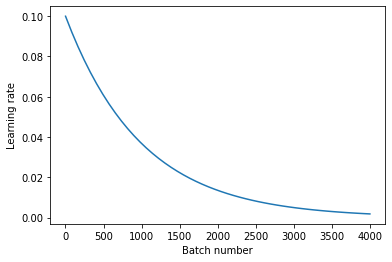

In [9]:
# Optimization hyperparameters
num_batchs = 4000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.999     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.plot(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [188]:
seed = 342343
print("Seed: %d" % seed)
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : False,
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 2,
}

toy_params['words'] = generateWordBank(toy_params)
# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda01')
# toy_params['words'].remove('kinda0')
# toy_params['words'].remove('kinda1')
toy_params['words'].remove('very0')
toy_params['words'].remove('very1')
# toy_params['sentiments'] = ['Red', 'Green', 'Blue']
toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

########## GRU hyperparameters ##########
gru_specs = {
  'input_size': len(toy_params['words']),           # Number of inputs to the GRU
  'hidden_size': 128,                               # Number of units in the GRU
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the GRU
  'ro_bias': False                                   # Include a bias with the readout
}

########## Optimization hyperparameters ##########

max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.00002           # amount of L2 regularization on the weights

init_lr = 0.1                     # initial learning rate
decay_factor = 0.999              # decay the learning rate this much
adam_b1 = 0.9                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
adam_b2 = 0.99
adam_eps = 1e-1

batch_size = 128                     # How many examples in each batch
num_batchs = 1000                    # Total number of batches to train on.
print_every = 100         # Print training informatino every so often

epochs = 2
train_set_size = batch_size * num_batchs
test_set_size = 200

decay_fun = optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor)

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = False
load_network = False
save_data = True

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/gru_2class_xe_noRO_3wordswcorr.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(gru_specs)
  input_shape = (batch_size, toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(learning_rate, adam_b1, adam_b2, adam_eps)
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=max_grad_norm)
  
  init_opt, update_opt, get_params = opt

  train_losses = []
  global_step = 0
  total_steps = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (batch_size, toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(learning_rate, adam_b1, adam_b2, adam_eps)
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=max_grad_norm)

  init_opt, update_opt, get_params = opt

  train_losses = []
  total_steps = train_params['total_steps']
  global_step = total_steps

# Run the optimization loop, first jit'd call will take a minute.
syn_data = generate_data(train_set_size, toy_params, gru_specs['output_size'])
syn_data_test = generate_data(test_set_size, toy_params, gru_specs['output_size'])

for epoch in range(epochs):

  # Shuffles training data
  if epoch > 0:
    print('Shuffling Data')
    syn_data = shuffle_data(syn_data)

  print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
  start_time = time.time()  
  avg_loss = 0 
  for step in range(total_steps, total_steps+num_batchs):
    batch = step - total_steps 
    batch_data = {
      'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
      'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
      'index': syn_data['index'], # Target mask: list of integers up to phrase_len
    }

    global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
    train_losses.append(loss)
    avg_loss += loss

    if (global_step+1) % print_every == 0:
      test_acc = test_accuracy(get_params(opt_state), syn_data_test)

      batch_time = time.time() - start_time
      step_size = decay_fun(global_step)
      s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
      print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
      start_time = time.time()
      avg_loss = 0

  total_steps += num_batchs

train_params = {'total_steps': total_steps, 'decay_factor': decay_factor, 'init_step_size': step_size, 
                  'batch_size': batch_size, 'max_grad_norm': max_grad_norm, 'l2reg': l2reg}

save_run_data(path, save_data, get_params(opt_state), toy_params, gru_specs, train_params)

# Destructure the trained parameters of the RNN.
#   rnn_params: The parameters of the RNN (GRU). 
#   readout_params: The parameters of the final readout layer.
final_params = get_params(opt_state)
rnn_params, readout_params = final_params

Seed: 342343
Total words: 3 Words: ['kinda0', 'kinda1', 'the']
Total sentiments: 2 Sentiments: ['sent0', 'sent1']
File already exists at: /content/drive/My Drive/ml_research/fixedpoints_nlp/gru_2class_xe_noRO_3wordswcorr.pickle
Override? (Y/N):Y
Sythentic data generated in: 37.38 sec.
Sythentic data generated in: 0.07 sec.


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'int'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'int'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Running batches 2000 to 3000
Step 2100 in 1.79 sec, step size: 0.01225, test acc 0.9800, avg training loss 0.0483
Step 2200 in 1.78 sec, step size: 0.01108, test acc 0.9700, avg training loss 0.0513
Step 2300 in 1.75 sec, step size: 0.01002, test acc 0.9750, avg training loss 0.0499
Step 2400 in 1.75 sec, step size: 0.00907, test acc 0.9750, avg training loss 0.0488
Step 2500 in 1.76 sec, step size: 0.00821, test acc 0.9750, avg training loss 0.0483
Step 2600 in 1.77 sec, step size: 0.00743, test acc 0.9700, avg training loss 0.0492
Step 2700 in 1.79 sec, step size: 0.00672, test acc 0.9750, avg training loss 0.0483
Step 2800 in 1.75 sec, step size: 0.00608, test acc 0.9750, avg training loss 0.0481
Step 2900 in 1.77 sec, step size: 0.00550, test acc 0.9750, avg training loss 0.0461
Step 3000 in 1.77 sec, step size: 0.00498, test acc 0.9750, avg training loss 0.0445
Shuffling Data
Running batches 3000 to 4000
Step 3100 in 1.75 sec, step size: 0.00450, test acc 0.9750, avg training loss

In [39]:
# Save the network
train_params = {'total_steps': total_steps, 'decay_factor': decay_factor, 'init_step_size': step_size, 
                  'batch_size': batch_size, 'max_grad_norm': max_grad_norm, 'l2reg': l2reg}

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classsrgb_xe_noRO_01corr.pickle'

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, gru_specs, train_params)

File already exists. Override? (Y/N):Y
Data Saved


In [96]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classsrgb_xe_noRO.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    gru_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded

print('Data Loaded')

Data Loaded


Text(0, 0.5, 'Train Loss')

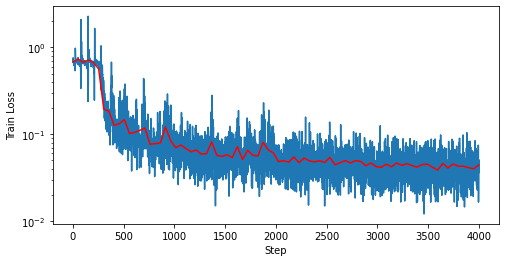

In [189]:
plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]


plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [190]:
# Here, we build some helper functions to collect RNN hidden states.

cell = renn.GRU(gru_specs['hidden_size'])

@jax.jit
def _get_all_states(inputs):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])
  return renn.unroll_rnn(initial_states, inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch, only_final=False):
  """Return (masked) RNN states."""
  states = _get_all_states(batch['inputs'])
  if only_final: # returns only the final hidden state
    return [h[batch['index'][0]] for h in states]
  else:
    return [h[:batch['index'][0]+1] for h in states]

In [191]:
# Get RNN hidden states in response to a test batch.
n_trials = 1000

syn_data_test = generate_data(n_trials, toy_params, gru_specs['output_size'])

hs = rnn_states(syn_data_test)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

if gru_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

Sythentic data generated in: 0.29 sec.


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'int'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'int'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


(25000, 128)


Top 5 components: 0.98435354 ( [0.87229633 0.06758396 0.02478536 0.01143815 0.00824978] )
Category 0 states: 498
Category 1 states: 502
Readout vec proj via PCA: [[ 2.6763551  -2.4695258 ]
 [ 0.6236505  -0.694044  ]
 [-0.1771922  -0.05916388]
 [ 0.12308188 -0.02872756]
 [ 0.31387475 -0.55678684]]


(128,)

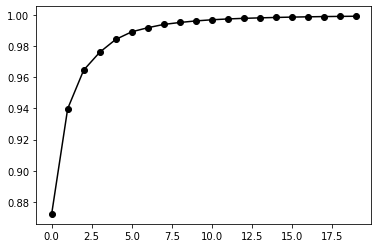

In [192]:
pc_dims = 5

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=gru_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
total_exvar = []
for i in range(gru_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)
comp = pca.components_ # pc_dims x n_hidden
print('Readout vec proj via PCA:', np.matmul(comp, readout.T))

# The initial state.
h0 = cell.get_initial_state(rnn_params)
h0.shape

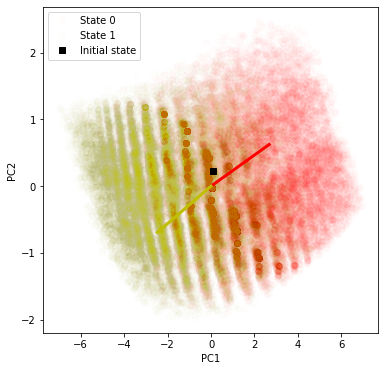

In [193]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  pca_states = pca.transform(np.vstack(states[i])).T
  plt.plot(pca_states[pc1], pca_states[pc2], state_colors[i]+'o', alpha=0.01, label=state_labels[i])


# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Readout Vector Analysis

In [172]:
# Percentage of readout vector mag in PCA dimensions

if gru_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

readout_mags = []
readout_pca_mags = []
pc_dims = 2
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

Readout 0 mag: 3.687487
Readout 0 (perc in first 2 PC dims): 0.9086627
Readout 1 mag: 3.5821137
Readout 1 (perc in first 2 PC dims): 0.8558466


In [44]:
def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x 1 vector
  Finds the percentage of b's magnitude which lies in the subspace formed by the columns of A (its columnspace)
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T)
  b_proj = np.matmul(proj, b)

  return np.linalg.norm(b_proj)/np.linalg.norm(b)

read_out_mags = []
for i in range(len(readout)):
  read_out_mags.append(np.linalg.norm(readout[i]))

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(read_out_mags[i]*read_out_mags[j])))

A01 = np.array([readout[0], readout[1]]).T
A02 = np.array([readout[0], readout[2]]).T
A12 = np.array([readout[1], readout[2]]).T

print('Perc of 2 in (0,1):', subspace_perc(A01, readout[2]))
print('Perc of 1 in (0,2):', subspace_perc(A02, readout[1]))
print('Perc of 0 in (1,2):', subspace_perc(A12, readout[0]))

Angle (1, 0): 107.7132170225033
Angle (2, 0): 133.29289018122637
Angle (2, 1): 110.63993942147543
Perc of 2 in (0,1): 0.90399563
Perc of 1 in (0,2): 0.82879776
Perc of 0 in (1,2): 0.900331


In [7]:
# Exact symplex numbers

simplex = []
simplex.append(np.asarray([1,0,0]))
simplex.append(np.asarray([-1/3, np.sqrt(8)/3, 0]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, np.sqrt(2/3)]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, -np.sqrt(2/3)]))

read_out_mags = []
for i in range(len(simplex)):
  read_out_mags.append(np.linalg.norm(simplex[i]))

print(read_out_mags)

for i in range(len(simplex)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(simplex[i], simplex[j])/(read_out_mags[i]*read_out_mags[j])))

A01 = np.array([simplex[0], simplex[1]]).T
A02 = np.array([simplex[0], simplex[2]]).T
A12 = np.array([simplex[1], simplex[2]]).T

print('Perc of 2 in (0,1):', subspace_perc(A01, simplex[2]))
print('Perc of 1 in (0,2):', subspace_perc(A02, simplex[1]))
print('Perc of 0 in (1,2):', subspace_perc(A12, simplex[0]))

[1.0, 1.0, 1.0, 1.0]
Angle (1, 0): 109.47122063449069
Angle (2, 0): 109.47122063449069
Angle (2, 1): 109.47122063449069
Angle (3, 0): 109.47122063449069
Angle (3, 1): 109.47122063449069
Angle (3, 2): 109.47122063449069
Perc of 2 in (0,1): 0.5773502691896258
Perc of 1 in (0,2): 0.5773502691896258
Perc of 0 in (1,2): 0.5773502691896257


### Input Jacobian Projections

In [197]:
def word_deflection(word, cell, toy_params, rnn_params, gru_specs, h0, comp):
  
  word_tensor = wordToTensor(word, toy_params['words'])
  input_jac = cell.inp_jac(rnn_params, jnp.zeros(gru_specs['input_size']), h0)
  hidden_update = np.matmul(input_jac, word_tensor[0])
  
  return np.matmul(comp, hidden_update)

### Find Fixed Points

In [194]:
fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)

fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts,
                                                            jnp.zeros((pts.shape[0], gru_specs['input_size'])),
                                                            optimizers.adam(0.01),
                                                            tolerance=1e-4)
print('Done')



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 1/10000 [00:00<35:49,  4.65it/s]

  0%|          | 36/10000 [00:00<25:08,  6.61it/s]

  1%|          | 72/10000 [00:00<17:40,  9.36it/s]

  1%|          | 104/10000 [00:00<12:29, 13.21it/s]

  1%|▏         | 139/10000 [00:00<08:51, 18.56it/s]

  2%|▏         | 175/10000 [00:00<06:18, 25.94it/s]

  2%|▏         | 210/10000 [00:00<04:32, 35.90it/s]

  2%|▏         | 246/10000 [00:00<03:18, 49.14it/s]

  3%|▎         | 283/10000 [00:01<02:26, 66.35it/s]

  3%|▎         | 319/10000 [00:01<01:50, 87.68it/s]

  4%|▎         | 355/10000 [00:01<01:25, 113.28it/s]

  4%|▍         | 391/10000 [00:01<01:07, 142.48it/s]

  4%|▍         | 428/10000 [00:01<00:54, 174.50it/s]

  5%|▍         | 465/10000 [00:01<00:46, 206.49it/s]

  5%|▌         | 502/10000 [00:01<00:39, 237.66it/s]

  5%|▌         | 539/10000 [00:01<00:35, 265.56it/s]

  6%|▌         | 576/10000 [00:01<00:32, 289.20it/s]

  6%|▌         | 613/10000 [00:01<00:30, 309.00it/s

Done


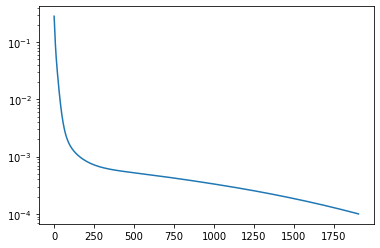

In [123]:
plt.semilogy(loss_hist)

Text(0, 0.5, 'PC2')

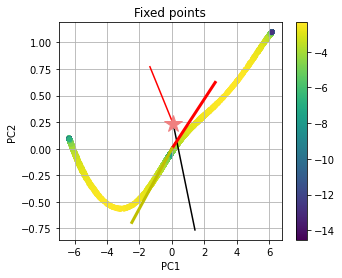

In [203]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, gru_specs, fixed_points[fp_idx], comp)
plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, gru_specs, fixed_points[fp_idx], comp)
plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, gru_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

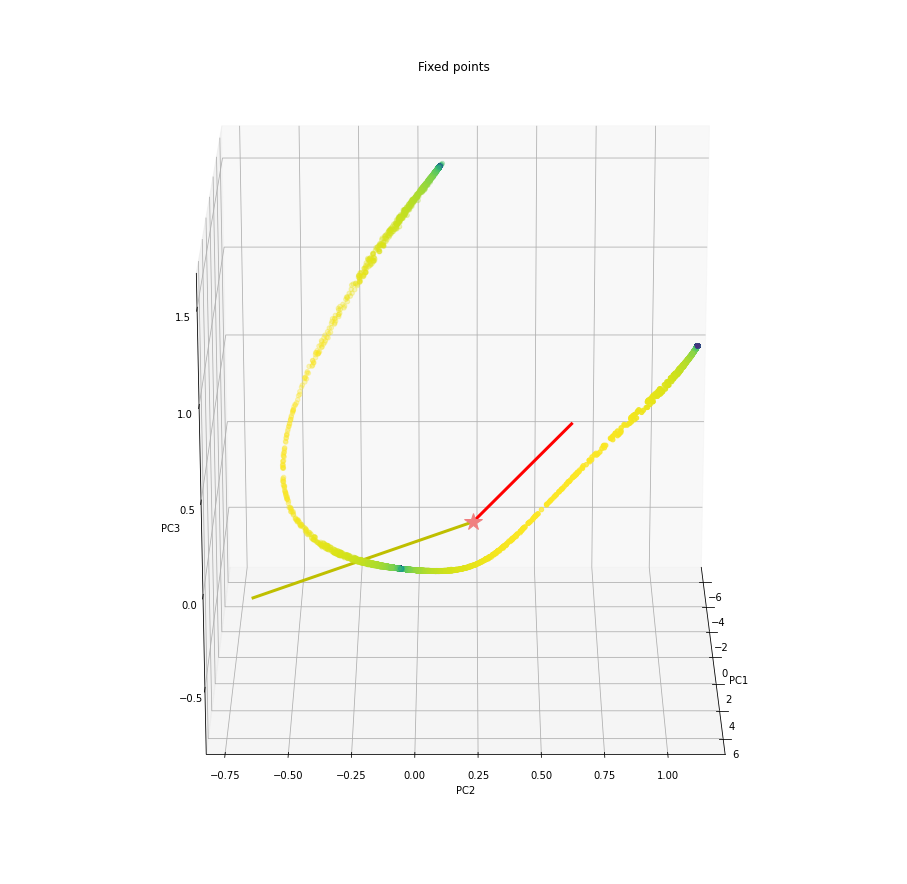

In [207]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation

pc1 = 0
pc2 = 1
pc3 = 2

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d');


pca_fps = pca.transform(np.vstack(fixed_points)).T
# max_loss = np.max(np.log10(fp_losses))
# min_loss = np.min(np.log10(fp_losses))
# loss_range = max_loss - min_loss
# colors = []
# for loss in fp_losses:
#   seq_color_norm = (np.log10(loss)-min_loss)/loss_range
#   colors.append((seq_color_norm, 0, 1 - seq_color_norm, 1.0))
# ax.plot_trisurf(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], edgecolor='none', color='grey')
ax.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))

# Plots readout direction
ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [pca_h0[pc1], ro_dir[pc1]]
  y_ro = [pca_h0[pc2], ro_dir[pc2]]
  z_ro = [pca_h0[pc3], ro_dir[pc2]]
  plt.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

# pca_word = 3*word_deflection('very1', cell, toy_params, rnn_params, gru_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 3*word_deflection('very0', cell, toy_params, rnn_params, gru_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, gru_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

ax.set_xlabel('PC'+str(pc1+1))
ax.set_ylabel('PC'+str(pc2+1))
ax.set_zlabel('PC'+str(pc3+1))

# Azimuthal angle and rotation
ax.view_init(20, 0)

#### Single Fixed Point Analysis

Text(0, 0.5, 'PC2')

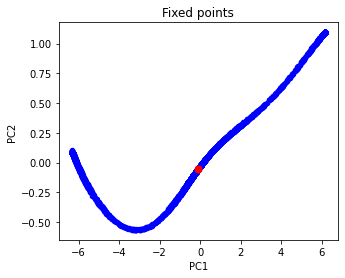

In [202]:
# Pick a fixed point.
# fp_idx = np.argmin(fp_losses)
fp_idx = 400
fp = fixed_points[fp_idx]

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')
plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='r')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [127]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(gru_specs['input_size']), fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

Text(0, 0.5, 'imag')

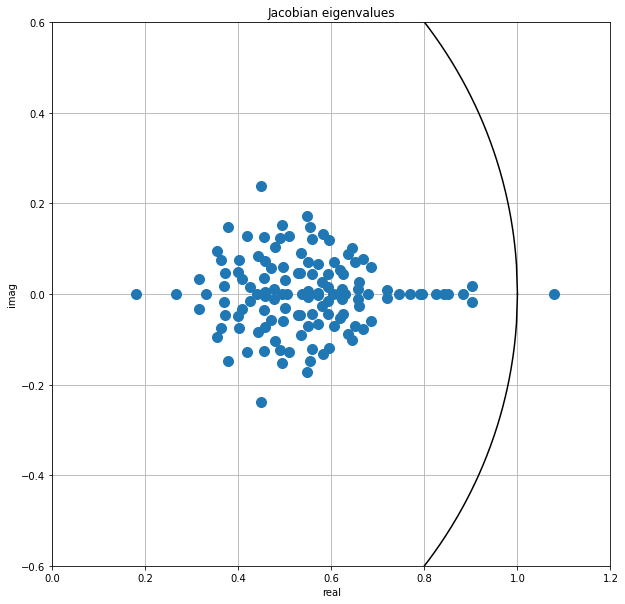

In [128]:
plt.figure(figsize=(10,10))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

#### Many Fixed Point Analysis

In [129]:
# Plots Jacobian eigenvalues as a function of fixed point

pca_fps = pca.transform(np.vstack(fixed_points)).T

# Sorts fixed points by pc dimension
sort_idxs = np.argsort(pca_fps[0])
sorted_pca_fps = pca_fps[0][sort_idxs]
sorted_fp = fixed_points[sort_idxs]

take_every = 10
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals = np.zeros((int(n_fp/take_every), 5))
pc_dim_val = np.zeros(int(n_fp/take_every))

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = sorted_fp[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(gru_specs['input_size']), fp))
  _, E, _ = renn.eigsorted(jac)
  rE = np.real(E)
  rE.sort()
  pc_dim_val[i] = sorted_pca_fps[i*take_every]
  max_evals[i] = rE[-5:]

Evaluating 25000 fixed points.


Text(0, 0.5, 'Max Re(Eigenvalues)')

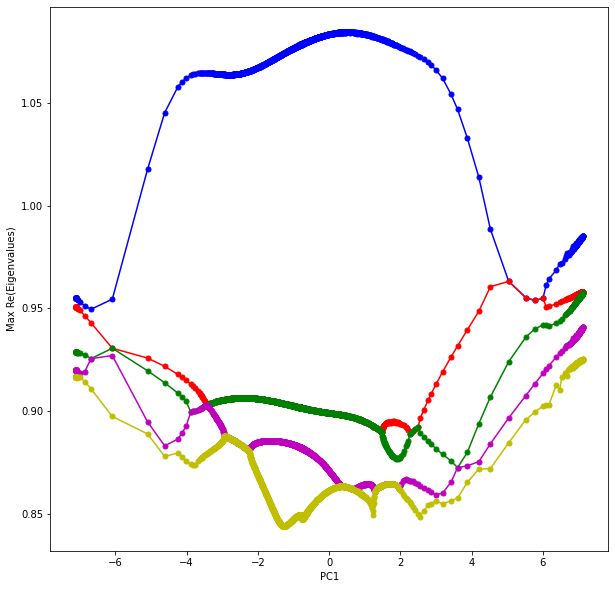

In [113]:
plt.figure(figsize=(10,10))
plt.plot(pc_dim_val, max_evals[:,4], '.-', ms=10, c='b')
plt.plot(pc_dim_val, max_evals[:,3], '.-', ms=10, c='r')
plt.plot(pc_dim_val, max_evals[:,2], '.-', ms=10, c='g')
plt.plot(pc_dim_val, max_evals[:,1], '.-', ms=10, c='m')
plt.plot(pc_dim_val, max_evals[:,0], '.-', ms=10, c='y')

plt.xlabel('PC1')
plt.ylabel('Max Re(Eigenvalues)')